In [ ]:
!pip install datasets
!pip install textstat
!pip install --upgrade datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.3/175.3 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.4/939.4 kB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 6.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6

In [ ]:
# System & Environment
import os
import random
import ast
import json

# Data Handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn - Modeling & Evaluation
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score
)

# Sparse matrix handling
from scipy.sparse import hstack, csr_matrix, issparse

# Readability / Linguistic Features
import textstat

# SHAP Interpretability
import shap

# Colab-specific
from google.colab import drive

# Set reproducibility
random.seed(42)
np.random.seed(42)
os.environ["PYTHONHASHSEED"] = "42"

# Mount Drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Preparation RACE (https://huggingface.co/datasets/ehovy/race)

In [ ]:
# Load your prepared CSV
df = pd.read_csv("/content/drive/My Drive/Master Thesis/RACE/race_confidence.csv")

# Drop rows with any critical missing values
required_columns = ["question", "choices", "answer_text", "entropy", "confidence_correct"]
df = df.dropna(subset=required_columns)

# Convert stringified list to list for 'choices' column
if isinstance(df.loc[0, "choices"], str) and df.loc[0, "choices"].startswith("["):
    import ast
    df["choices"] = df["choices"].apply(ast.literal_eval)

# Reset index for K-Fold
df = df.sort_values("id").reset_index(drop=True)
df.head()

,id,passage,question,choices,answer_key,difficulty,answer_text,entropy,confidence_correct
0,high10005.txt,Course A: Understanding computers\n1. A twelve...,"If you want to take Course A, you need to go ...","[twice every week, three times a week, four ti...",C,high,four times altogether,0.450958,0.832186
1,high10010.txt,Stay in the magic with your friends and family...,"As a guest at Hong Kong Disneyland Hotel, you ...","[Hong Kong Disneyland Park, a Hong Kong family...",A,high,Hong Kong Disneyland Park,0.321922,0.885198
2,high10021.txt,When it comes to feeling better about yourself...,The natural and healthy eating can NOT _ .,"[help one lose weight, burn fat in one's body,...",C,high,decrease one's energy,0.728446,0.639088
3,high10022.txt,"In 1977, Irene Pepperberg of Harvard Universit...",Alex learnt new words by _ .,"[singing them, reading them, writing them, reh...",D,high,rehearing them,0.834409,0.381261
4,high10024.txt,One thinks of princes and presidents as some o...,The Sherman Antitrust Act _ .,[affected only the companies doing business wi...,B,high,sought to eliminate monopolies in favor of com...,0.042137,0.991317


# Baseline

### Majority Class Baseline

In [ ]:
def majority_class_baseline(df):
    most_common = df["difficulty"].value_counts().idxmax()
    baseline_acc = df["difficulty"].value_counts().max() / len(df) * 100
    print(f"Majority Class Baseline: Always Predict '{most_common}' → Accuracy: {baseline_acc:.2f}%")


print("\nRACE Dataset Majority Class Baseline:")
majority_class_baseline(df)


RACE Dataset Majority Class Baseline:
Majority Class Baseline: Always Predict 'high' → Accuracy: 74.44%


In [ ]:
def majority_class_macro_f1(y_true):
    most_common = y_true.value_counts().idxmax()
    y_pred = [most_common] * len(y_true)
    return most_common, f1_score(y_true, y_pred, average='macro')

most_common, macro_f1_baseline = majority_class_macro_f1(df["difficulty"])
print(f"Majority Class Baseline (Macro F1): Always Predict '{most_common}' → F1-score: {macro_f1_baseline:.4f}")

Majority Class Baseline (Macro F1): Always Predict 'high' → F1-score: 0.4267


#### Baseline

In [ ]:
def vectorize_data(train_df, test_df):
    # Vectorizes combined text (question + choices + passage) using TF-IDF.
    train_df["combined_text"] = train_df["question"] + " " + train_df["choices"].apply(lambda x: " ".join(x)) + " " + train_df["passage"]
    test_df["combined_text"] = test_df["question"] + " " + test_df["choices"].apply(lambda x: " ".join(x)) + " " + test_df["passage"]

    vectorizer = TfidfVectorizer(max_features=5000, stop_words="english")
    X_train = vectorizer.fit_transform(train_df["combined_text"])
    X_test = vectorizer.transform(test_df["combined_text"])

    y_train = train_df["difficulty"]
    y_test = test_df["difficulty"]

    return X_train, X_test, y_train, y_test, vectorizer

In [ ]:
models = {
    "Logistic Regression": LogisticRegression(class_weight="balanced", max_iter=1000, random_state=42),
    "Naive Bayes": MultinomialNB(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "KNN": KNeighborsClassifier(),
    "SVM": LinearSVC(random_state=42)
}

k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
for model_name, model in models.items():
    print(f"\n=== {model_name} ({k}-Fold Average) ===")
    all_preds = []
    all_targets = []

    for train_idx, test_idx in skf.split(df["question"], df["difficulty"]):
        train_df = df.iloc[train_idx].copy()
        test_df = df.iloc[test_idx].copy()

        X_train, X_test, y_train, y_test, vectorizer = vectorize_data(train_df, test_df)

        model.fit(X_train, y_train)
        preds = model.predict(X_test)

        all_preds.extend(preds)
        all_targets.extend(y_test)

    acc = accuracy_score(all_targets, all_preds)
    print(f"Average Accuracy: {acc:.4f}")
    print(classification_report(all_targets, all_preds, zero_division=0))


=== Logistic Regression (5-Fold Average) ===
Average Accuracy: 0.8224
              precision    recall  f1-score   support

        high       0.90      0.85      0.88      4159
      middle       0.63      0.74      0.68      1428

    accuracy                           0.82      5587
   macro avg       0.77      0.79      0.78      5587
weighted avg       0.83      0.82      0.83      5587


=== Naive Bayes (5-Fold Average) ===
Average Accuracy: 0.8067
              precision    recall  f1-score   support

        high       0.81      0.97      0.88      4159
      middle       0.78      0.34      0.47      1428

    accuracy                           0.81      5587
   macro avg       0.80      0.65      0.68      5587
weighted avg       0.80      0.81      0.78      5587


=== Decision Tree (5-Fold Average) ===
Average Accuracy: 0.7113
              precision    recall  f1-score   support

        high       0.82      0.79      0.80      4159
      middle       0.44      0.48     

# Baseline only trained on Entropy/Confidence

In [ ]:
def vectorize_entropy_only(train_df, test_df):
    for col in ["entropy"]:
        train_df[col] = train_df[col].fillna(0)
        test_df[col] = test_df[col].fillna(0)
    X_train = csr_matrix(train_df[["entropy"]].values)
    X_test = csr_matrix(test_df[["entropy"]].values)
    y_train = train_df["difficulty"]
    y_test = test_df["difficulty"]
    return X_train, X_test, y_train, y_test

def vectorize_confidence_only(train_df, test_df):
    for col in ["confidence_correct"]:
        train_df[col] = train_df[col].fillna(0)
        test_df[col] = test_df[col].fillna(0)
    X_train = csr_matrix(train_df[["confidence_correct"]].values)
    X_test = csr_matrix(test_df[["confidence_correct"]].values)
    y_train = train_df["difficulty"]
    y_test = test_df["difficulty"]
    return X_train, X_test, y_train, y_test

def vectorize_entropy_confidence(train_df, test_df):
    for col in ["entropy", "confidence_correct"]:
        train_df[col] = train_df[col].fillna(0)
        test_df[col] = test_df[col].fillna(0)
    X_train = csr_matrix(train_df[["entropy", "confidence_correct"]].values)
    X_test = csr_matrix(test_df[["entropy", "confidence_correct"]].values)
    y_train = train_df["difficulty"]
    y_test = test_df["difficulty"]
    return X_train, X_test, y_train, y_test


In [ ]:
improved_models = {
    "Logistic Regression": LogisticRegression(C=0.05, class_weight="balanced", max_iter=1000, random_state=42),
    "Naive Bayes": MultinomialNB(),
    "SVM": LinearSVC(random_state=42),
    "Decision Tree": DecisionTreeClassifier(
                      class_weight="balanced",
                      max_depth=20,
                      min_samples_leaf=3,
                      random_state=42
                      ),
    "Random Forest": RandomForestClassifier(
                        class_weight="balanced",
                        n_estimators=300,
                        max_depth=15,
                        min_samples_leaf=5,
                        random_state=42,
                        n_jobs=-1
                        ),
    "KNN": KNeighborsClassifier()
}

vectorizers = {
    "Only Entropy": vectorize_entropy_only,
    "Only Confidence": vectorize_confidence_only,
    "Entropy + Confidence": vectorize_entropy_confidence
}

k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
for setting_name, vectorizer_fn in vectorizers.items():
    print(f"\n=== {setting_name} | {k}-Fold Average) ===")

    for model_name, model in improved_models.items():
        all_preds = []
        all_targets = []

        for train_idx, test_idx in skf.split(df["question"], df["difficulty"]):
            train_df = df.iloc[train_idx].copy()
            test_df = df.iloc[test_idx].copy()

            X_train, X_test, y_train, y_test = vectorizer_fn(train_df, test_df)

            model.fit(X_train, y_train)
            preds = model.predict(X_test)

            all_preds.extend(preds)
            all_targets.extend(y_test)

        acc = accuracy_score(all_targets, all_preds)
        print(f"\n{model_name} | Accuracy: {acc:.4f}")
        print(classification_report(all_targets, all_preds, zero_division=0))


=== Only Entropy | 5-Fold Average) ===

Logistic Regression | Accuracy: 0.5737
              precision    recall  f1-score   support

        high       0.77      0.61      0.68      4159
      middle       0.29      0.47      0.36      1428

    accuracy                           0.57      5587
   macro avg       0.53      0.54      0.52      5587
weighted avg       0.65      0.57      0.60      5587


Naive Bayes | Accuracy: 0.7444
              precision    recall  f1-score   support

        high       0.74      1.00      0.85      4159
      middle       0.00      0.00      0.00      1428

    accuracy                           0.74      5587
   macro avg       0.37      0.50      0.43      5587
weighted avg       0.55      0.74      0.64      5587


SVM | Accuracy: 0.7444
              precision    recall  f1-score   support

        high       0.74      1.00      0.85      4159
      middle       0.00      0.00      0.00      1428

    accuracy                           0.74   

Improving the Baseline Model
* Lowering C value in LR to fix under-regularization.

Fix overfitting for Tree Models (good for feature importance):
* max_depth=5 Limits depth prevents the tree from growing too deep and memorizing
* min_samples_leaf=10 each leaf must have at least 10 examples, reducing splits on noise
* n_estimators=100 (RF) More trees helps Random Forest generalize better by averaging

In [ ]:
improved_models = {
        "Logistic Regression": LogisticRegression(C=0.05, class_weight="balanced", max_iter=1000, random_state=42),
        "Naive Bayes": MultinomialNB(),
        "SVM": LinearSVC(random_state=42),
        "Decision Tree": DecisionTreeClassifier(
                          class_weight="balanced",
                          max_depth=20,
                          min_samples_leaf=3,
                          random_state=42
                          ),
        "Random Forest": RandomForestClassifier(
                            class_weight="balanced",
                            n_estimators=300,
                            max_depth=15,
                            min_samples_leaf=5,
                            random_state=42,
                            n_jobs=-1
                            ),
        "KNN": KNeighborsClassifier()
        }

k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
for model_name, model in models.items():
    print(f"\n=== {model_name} ({k}-Fold Average) ===")
    all_preds = []
    all_targets = []

    for train_idx, test_idx in skf.split(df["question"], df["difficulty"]):
        train_df = df.iloc[train_idx].copy()
        test_df = df.iloc[test_idx].copy()

        X_train, X_test, y_train, y_test, vectorizer = vectorize_data(train_df, test_df)

        model.fit(X_train, y_train)
        preds = model.predict(X_test)

        all_preds.extend(preds)
        all_targets.extend(y_test)

    acc = accuracy_score(all_targets, all_preds)
    print(f"Average Accuracy: {acc:.4f}")
    print(classification_report(all_targets, all_preds, zero_division=0))


=== Logistic Regression (5-Fold Average) ===
Average Accuracy: 0.8224
              precision    recall  f1-score   support

        high       0.90      0.85      0.88      4159
      middle       0.63      0.74      0.68      1428

    accuracy                           0.82      5587
   macro avg       0.77      0.79      0.78      5587
weighted avg       0.83      0.82      0.83      5587


=== Naive Bayes (5-Fold Average) ===
Average Accuracy: 0.8067
              precision    recall  f1-score   support

        high       0.81      0.97      0.88      4159
      middle       0.78      0.34      0.47      1428

    accuracy                           0.81      5587
   macro avg       0.80      0.65      0.68      5587
weighted avg       0.80      0.81      0.78      5587


=== Decision Tree (5-Fold Average) ===
Average Accuracy: 0.7113
              precision    recall  f1-score   support

        high       0.82      0.79      0.80      4159
      middle       0.44      0.48     

# Baseline with Entropy

In [ ]:
def vectorize_and_add_entropy(train_df, test_df):
    # Vectorizes question + choices + passage using TF-IDF and adds handcrafted + entropy/confidence features.
    for col in ["entropy"]:
        train_df[col] = train_df[col].fillna(0)
        test_df[col] = test_df[col].fillna(0)

    # Text to vectorize (include passage)
    train_df["combined_text"] = train_df["question"] + " " + train_df["choices"].apply(lambda x: " ".join(x)) + " " + train_df["passage"]
    test_df["combined_text"] = test_df["question"] + " " + test_df["choices"].apply(lambda x: " ".join(x)) + " " + test_df["passage"]

    # TF-IDF vectorization
    vectorizer = TfidfVectorizer(max_features=5000, stop_words="english")
    X_train_text = vectorizer.fit_transform(train_df["combined_text"])
    X_test_text = vectorizer.transform(test_df["combined_text"])

    # Extra features
    feature_cols = ["entropy"]
    X_train_features = train_df[feature_cols].values
    X_test_features = test_df[feature_cols].values

    # Combine sparse text + dense numeric features
    X_train = hstack([X_train_text, X_train_features])
    X_test = hstack([X_test_text, X_test_features])

    y_train = train_df["difficulty"]
    y_test = test_df["difficulty"]

    return X_train, X_test, y_train, y_test, vectorizer

In [ ]:
improved_models = {
        "Logistic Regression": LogisticRegression(C=0.05, class_weight="balanced", max_iter=1000, random_state=42),
        "Naive Bayes": MultinomialNB(),
        "SVM": LinearSVC(random_state=42),
        "Decision Tree": DecisionTreeClassifier(
                          class_weight="balanced",
                          max_depth=20,
                          min_samples_leaf=3,
                          random_state=42
                          ),
        "Random Forest": RandomForestClassifier(
                            class_weight="balanced",
                            n_estimators=300,
                            max_depth=15,
                            min_samples_leaf=5,
                            random_state=42,
                            n_jobs=-1
                            ),
        "KNN": KNeighborsClassifier()
        }

k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
for model_name, model in models.items():
    print(f"\n=== {model_name} (Improved + Extra Features | {k}-Fold Average) ===")
    all_preds = []
    all_targets = []

    for train_idx, test_idx in skf.split(df["question"], df["difficulty"]):
        train_df = df.iloc[train_idx].copy()
        test_df = df.iloc[test_idx].copy()

        X_train, X_test, y_train, y_test, vectorizer = vectorize_and_add_entropy(train_df, test_df)

        model.fit(X_train, y_train)
        preds = model.predict(X_test)

        all_preds.extend(preds)
        all_targets.extend(y_test)

    acc = accuracy_score(all_targets, all_preds)
    print(f"Average Accuracy: {acc:.4f}")
    print(classification_report(all_targets, all_preds, zero_division=0))


=== Logistic Regression (Improved + Extra Features | 5-Fold Average) ===
Average Accuracy: 0.8228
              precision    recall  f1-score   support

        high       0.90      0.85      0.88      4159
      middle       0.63      0.73      0.68      1428

    accuracy                           0.82      5587
   macro avg       0.77      0.79      0.78      5587
weighted avg       0.83      0.82      0.83      5587


=== Naive Bayes (Improved + Extra Features | 5-Fold Average) ===
Average Accuracy: 0.8053
              precision    recall  f1-score   support

        high       0.81      0.97      0.88      4159
      middle       0.80      0.32      0.45      1428

    accuracy                           0.81      5587
   macro avg       0.80      0.65      0.67      5587
weighted avg       0.80      0.81      0.77      5587


=== Decision Tree (Improved + Extra Features | 5-Fold Average) ===
Average Accuracy: 0.7106
              precision    recall  f1-score   support

        

# Baseline with Confidence

In [ ]:
def vectorize_and_add_confidence(train_df, test_df):
    # Vectorizes question + choices + passage using TF-IDF and adds handcrafted + entropy/confidence features.
    for col in ["confidence_correct"]:
        train_df[col] = train_df[col].fillna(0)
        test_df[col] = test_df[col].fillna(0)

    # Text to vectorize (include passage)
    train_df["combined_text"] = train_df["question"] + " " + train_df["choices"].apply(lambda x: " ".join(x)) + " " + train_df["passage"]
    test_df["combined_text"] = test_df["question"] + " " + test_df["choices"].apply(lambda x: " ".join(x)) + " " + test_df["passage"]

    # TF-IDF vectorization
    vectorizer = TfidfVectorizer(max_features=5000, stop_words="english")
    X_train_text = vectorizer.fit_transform(train_df["combined_text"])
    X_test_text = vectorizer.transform(test_df["combined_text"])

    # Extra features
    feature_cols = ["confidence_correct"]
    X_train_features = train_df[feature_cols].values
    X_test_features = test_df[feature_cols].values

    # Combine sparse text + dense numeric features
    X_train = hstack([X_train_text, X_train_features])
    X_test = hstack([X_test_text, X_test_features])

    y_train = train_df["difficulty"]
    y_test = test_df["difficulty"]

    return X_train, X_test, y_train, y_test, vectorizer

In [ ]:
improved_models = {
        "Logistic Regression": LogisticRegression(C=0.05, class_weight="balanced", max_iter=1000, random_state=42),
        "Naive Bayes": MultinomialNB(),
        "SVM": LinearSVC(random_state=42),
        "Decision Tree": DecisionTreeClassifier(
                          class_weight="balanced",
                          max_depth=20,
                          min_samples_leaf=3,
                          random_state=42
                          ),
        "Random Forest": RandomForestClassifier(
                            class_weight="balanced",
                            n_estimators=300,
                            max_depth=15,
                            min_samples_leaf=5,
                            random_state=42,
                            n_jobs=-1
                            ),
        "KNN": KNeighborsClassifier()
        }

k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
for model_name, model in models.items():
    print(f"\n=== {model_name} (Improved + Extra Features | {k}-Fold Average) ===")
    all_preds = []
    all_targets = []

    for train_idx, test_idx in skf.split(df["question"], df["difficulty"]):
        train_df = df.iloc[train_idx].copy()
        test_df = df.iloc[test_idx].copy()

        X_train, X_test, y_train, y_test, vectorizer = vectorize_and_add_confidence(train_df, test_df)

        model.fit(X_train, y_train)
        preds = model.predict(X_test)

        all_preds.extend(preds)
        all_targets.extend(y_test)

    acc = accuracy_score(all_targets, all_preds)
    print(f"Average Accuracy: {acc:.4f}")
    print(classification_report(all_targets, all_preds, zero_division=0))


=== Logistic Regression (Improved + Extra Features | 5-Fold Average) ===
Average Accuracy: 0.8226
              precision    recall  f1-score   support

        high       0.91      0.85      0.88      4159
      middle       0.63      0.74      0.68      1428

    accuracy                           0.82      5587
   macro avg       0.77      0.80      0.78      5587
weighted avg       0.84      0.82      0.83      5587


=== Naive Bayes (Improved + Extra Features | 5-Fold Average) ===
Average Accuracy: 0.8071
              precision    recall  f1-score   support

        high       0.81      0.97      0.88      4159
      middle       0.79      0.34      0.47      1428

    accuracy                           0.81      5587
   macro avg       0.80      0.65      0.68      5587
weighted avg       0.80      0.81      0.78      5587


=== Decision Tree (Improved + Extra Features | 5-Fold Average) ===
Average Accuracy: 0.7050
              precision    recall  f1-score   support

        

# Baseline with Entropy and Confidence

In [ ]:
def vectorize_and_add_entropy_confidence(train_df, test_df):
   # Vectorizes question + choices + passage using TF-IDF and adds handcrafted + entropy/confidence features.
    for col in ["entropy", "confidence_correct"]:
        train_df[col] = train_df[col].fillna(0)
        test_df[col] = test_df[col].fillna(0)

    # Text to vectorize (include passage)
    train_df["combined_text"] = train_df["question"] + " " + train_df["choices"].apply(lambda x: " ".join(x)) + " " + train_df["passage"]
    test_df["combined_text"] = test_df["question"] + " " + test_df["choices"].apply(lambda x: " ".join(x)) + " " + test_df["passage"]

    # TF-IDF vectorization
    vectorizer = TfidfVectorizer(max_features=5000, stop_words="english")
    X_train_text = vectorizer.fit_transform(train_df["combined_text"])
    X_test_text = vectorizer.transform(test_df["combined_text"])

    # Extra features
    feature_cols = ["entropy", "confidence_correct"]
    X_train_features = train_df[feature_cols].values
    X_test_features = test_df[feature_cols].values

    # Combine sparse text + dense numeric features
    X_train = hstack([X_train_text, X_train_features])
    X_test = hstack([X_test_text, X_test_features])

    y_train = train_df["difficulty"]
    y_test = test_df["difficulty"]

    return X_train, X_test, y_train, y_test, vectorizer

In [ ]:
improved_models = {
        "Logistic Regression": LogisticRegression(C=0.05, class_weight="balanced", max_iter=1000, random_state=42),
        "Naive Bayes": MultinomialNB(),
        "SVM": LinearSVC(random_state=42),
        "Decision Tree": DecisionTreeClassifier(
                          class_weight="balanced",
                          max_depth=20,
                          min_samples_leaf=3,
                          random_state=42
                          ),
        "Random Forest": RandomForestClassifier(
                            class_weight="balanced",
                            n_estimators=300,
                            max_depth=15,
                            min_samples_leaf=5,
                            random_state=42,
                            n_jobs=-1
                            ),
        "KNN": KNeighborsClassifier()
        }

k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
for model_name, model in models.items():
    print(f"\n=== {model_name} (Improved + Extra Features | {k}-Fold Average) ===")
    all_preds = []
    all_targets = []

    for train_idx, test_idx in skf.split(df["question"], df["difficulty"]):
        train_df = df.iloc[train_idx].copy()
        test_df = df.iloc[test_idx].copy()

        X_train, X_test, y_train, y_test, vectorizer = vectorize_and_add_entropy_confidence(train_df, test_df)

        model.fit(X_train, y_train)
        preds = model.predict(X_test)

        all_preds.extend(preds)
        all_targets.extend(y_test)

    acc = accuracy_score(all_targets, all_preds)
    print(f"Average Accuracy: {acc:.4f}")
    print(classification_report(all_targets, all_preds, zero_division=0))


=== Logistic Regression (Improved + Extra Features | 5-Fold Average) ===
Average Accuracy: 0.8207
              precision    recall  f1-score   support

        high       0.90      0.85      0.88      4159
      middle       0.63      0.73      0.68      1428

    accuracy                           0.82      5587
   macro avg       0.77      0.79      0.78      5587
weighted avg       0.83      0.82      0.83      5587


=== Naive Bayes (Improved + Extra Features | 5-Fold Average) ===
Average Accuracy: 0.8045
              precision    recall  f1-score   support

        high       0.81      0.97      0.88      4159
      middle       0.80      0.32      0.45      1428

    accuracy                           0.80      5587
   macro avg       0.80      0.64      0.67      5587
weighted avg       0.80      0.80      0.77      5587


=== Decision Tree (Improved + Extra Features | 5-Fold Average) ===
Average Accuracy: 0.6997
              precision    recall  f1-score   support

        

#Extra Features

## Length-based

*   Question Length
*   Passage Length
*   Average Choice Length



In [ ]:
def count_words(text):
    # Returns the number of words in a string.
    return len(text.split()) if isinstance(text, str) else 0

def avg_choice_length(choices):
    # Returns the average number of words across all choices (list of strings).
    if isinstance(choices, list) and all(isinstance(c, str) for c in choices):
        lengths = [count_words(c) for c in choices]
        return sum(lengths) / len(lengths) if lengths else 0
    return 0

def extract_length_features(df):
    # Adds word count features for question, answer, and choices.
    df["question_length"] = df["question"].apply(count_words)
    df["passage_length"] = df["passage"].apply(count_words)
    df["avg_choice_length"] = df["choices"].apply(avg_choice_length)

    return df

## Lexical Complexity


*   Average Word Length
*   Lexical Diversity (unique words/total words)



In [ ]:
def average_word_length(text):
    # Returns the average word length in a given text.
    if isinstance(text, str):
        words = text.split()
        return sum(len(word) for word in words) / len(words) if words else 0
    return 0

def lexical_diversity(text):
    # Returns the lexical diversity (unique words / total words) in a given text.
    if isinstance(text, str):
        words = text.split()
        return len(set(words)) / len(words) if words else 0
    return 0

def extract_lexical_features(df):
    # Adds lexical complexity features like avg word length and lexical diversity.
    df["avg_word_length"] = df["question"].apply(average_word_length)
    df["lexical_diversity"] = df["question"].apply(lexical_diversity)

    return df



## Readability Features

*   Flesch Reading Ease Score (Higher = Easier)
*   Flesch-Kincaid Grade Level (Higher = Harder)



In [ ]:
def calculate_flesch_reading_ease(text):
    return max(textstat.flesch_reading_ease(text), 0) if isinstance(text, str) else 0

def calculate_flesch_kincaid_grade(text):
    return max(textstat.flesch_kincaid_grade(text), 0) if isinstance(text, str) else 0

def extract_readability_features(df):
    # Adds readability features to the dataframe.
    df["flesch_reading_ease"] = df["question"].apply(calculate_flesch_reading_ease)
    df["flesch_kincaid_grade"] = df["question"].apply(calculate_flesch_kincaid_grade)

    return df

## Baseline with Features

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

def vectorize_and_add_features(train_df, test_df):
    # Vectorizes question + choices + passage using TF-IDF and adds handcrafted + entropy/confidence features.
    train_df = extract_length_features(train_df)
    test_df = extract_length_features(test_df)

    train_df = extract_lexical_features(train_df)
    test_df = extract_lexical_features(test_df)

    train_df = extract_readability_features(train_df)
    test_df = extract_readability_features(test_df)

    # Ensure entropy/confidence exist
    for col in ["entropy", "confidence_correct"]:
        train_df[col] = train_df[col].fillna(0)
        test_df[col] = test_df[col].fillna(0)

    # Text to vectorize (include passage)
    train_df["combined_text"] = train_df["question"] + " " + train_df["choices"].apply(lambda x: " ".join(x)) + " " + train_df["passage"]
    test_df["combined_text"] = test_df["question"] + " " + test_df["choices"].apply(lambda x: " ".join(x)) + " " + test_df["passage"]

    # TF-IDF vectorization
    vectorizer = TfidfVectorizer(max_features=5000, stop_words="english")
    X_train_text = vectorizer.fit_transform(train_df["combined_text"])
    X_test_text = vectorizer.transform(test_df["combined_text"])

    # Extra features
    feature_cols = [
        "question_length", "avg_choice_length", "passage_length",
        "flesch_reading_ease", "flesch_kincaid_grade",
        "avg_word_length", "lexical_diversity",
        "entropy", "confidence_correct"
    ]
    X_train_features = train_df[feature_cols].values
    X_test_features = test_df[feature_cols].values

    # Combine sparse text + dense numeric features
    X_train = hstack([X_train_text, X_train_features])
    X_test = hstack([X_test_text, X_test_features])

    y_train = train_df["difficulty"]
    y_test = test_df["difficulty"]

    return X_train, X_test, y_train, y_test, vectorizer


In [ ]:
improved_models = {
        "Logistic Regression": LogisticRegression(C=0.05, class_weight="balanced", max_iter=1000, random_state=42),
        "Naive Bayes": MultinomialNB(),
        "SVM": LinearSVC(random_state=42),
        "Decision Tree": DecisionTreeClassifier(
                          class_weight="balanced",
                          max_depth=20,
                          min_samples_leaf=3,
                          random_state=42
                          ),
        "Random Forest": RandomForestClassifier(
                            class_weight="balanced",
                            n_estimators=300,
                            max_depth=15,
                            min_samples_leaf=5,
                            random_state=42,
                            n_jobs=-1
                            ),
        "KNN": KNeighborsClassifier()
        }

k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
for model_name, model in models.items():
    print(f"\n=== {model_name} (Improved + Extra Features | {k}-Fold Average) ===")
    all_preds = []
    all_targets = []

    for train_idx, test_idx in skf.split(df["question"], df["difficulty"]):
        train_df = df.iloc[train_idx].copy()
        test_df = df.iloc[test_idx].copy()

        X_train, X_test, y_train, y_test, vectorizer = vectorize_and_add_features(train_df, test_df)

        model.fit(X_train, y_train)
        preds = model.predict(X_test)

        all_preds.extend(preds)
        all_targets.extend(y_test)

    # Final aggregated report
    acc = accuracy_score(all_targets, all_preds)
    print(f"Average Accuracy: {acc:.4f}")
    print(classification_report(all_targets, all_preds, zero_division=0))


=== Logistic Regression (Improved + Extra Features | 5-Fold Average) ===


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Average Accuracy: 0.8369
              precision    recall  f1-score   support

        high       0.92      0.85      0.89      4159
      middle       0.65      0.79      0.71      1428

    accuracy                           0.84      5587
   macro avg       0.79      0.82      0.80      5587
weighted avg       0.85      0.84      0.84      5587


=== Naive Bayes (Improved + Extra Features | 5-Fold Average) ===
Average Accuracy: 0.7977
              precision    recall  f1-score   support

        high       0.88      0.84      0.86      4159
      middle       0.59      0.67      0.63      1428

    accuracy                           0.80      5587
   macro avg       0.74      0.76      0.75      5587
weighted avg       0.81      0.80      0.80      5587


=== Decision Tree (Improved + Extra Features | 5-Fold Average) ===
Average Accuracy: 0.7718
              precision    recall  f1-score   support

        high       0.85      0.84      0.85      4159
      middle       0.55     

/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Average Accuracy: 0.5869
              precision    recall  f1-score   support

        high       0.81      0.59      0.68      4159
      middle       0.33      0.59      0.42      1428

    accuracy                           0.59      5587
   macro avg       0.57      0.59      0.55      5587
weighted avg       0.68      0.59      0.61      5587



/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [ ]:
def plot_shap_race(model, X_sparse, vectorizer, extra_feature_array=None, extra_feature_names=None, target_class="high", title="SHAP-Plot: RACE"):
    # Combine feature names
    tfidf_feature_names = [f'"{w}"' for w in vectorizer.get_feature_names_out()]
    if extra_feature_names:
        feature_names = tfidf_feature_names + extra_feature_names
    else:
        feature_names = tfidf_feature_names

    # Convert X to dense and combine
    X_dense = X_sparse.toarray() if issparse(X_sparse) else np.asarray(X_sparse)
    X_combined = np.hstack([X_dense, extra_feature_array]) if extra_feature_array is not None else X_dense

    # Compute SHAP values
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_combined)

    #  Get correct class index
    if isinstance(shap_values, list):
        class_idx = list(model.classes_).index(target_class)
        shap_values = shap_values[class_idx]
    elif shap_values.ndim == 3:
        class_idx = list(model.classes_).index(target_class)
        shap_values = shap_values[:, :, class_idx]

    # Plot
    shap.summary_plot(shap_values, X_combined, feature_names=feature_names, show=True)

/tmp/ipython-input-22-485376064.py:26: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_combined, feature_names=feature_names, show=True)


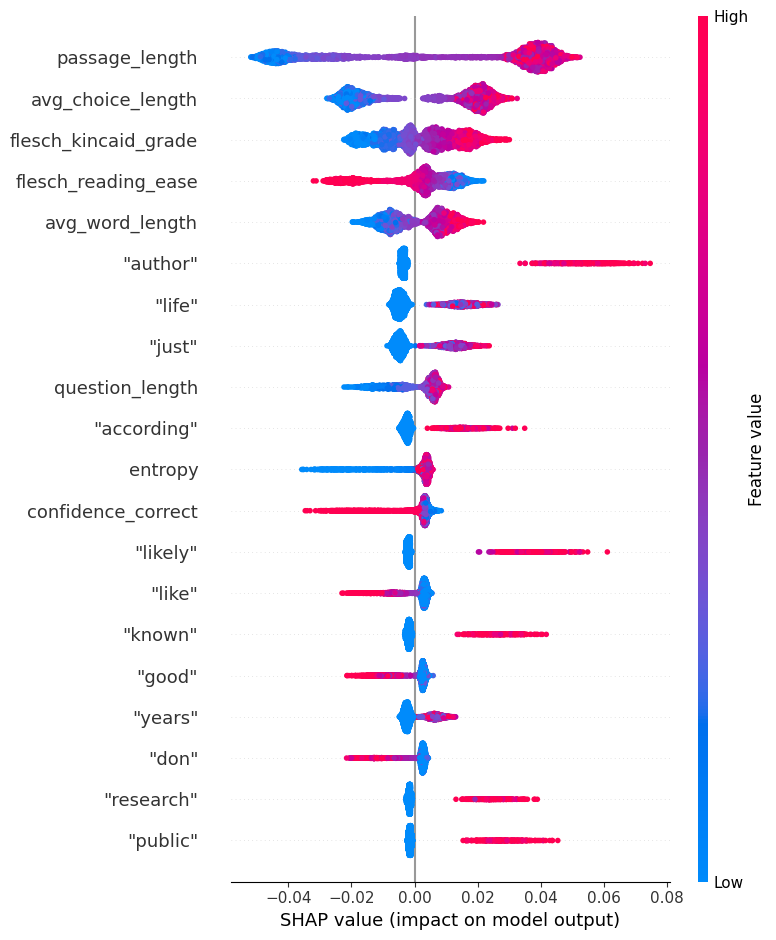

In [ ]:
extra_features = ["question_length", "avg_choice_length", "passage_length",
                  "flesch_reading_ease", "flesch_kincaid_grade", "avg_word_length",
                  "lexical_diversity", "entropy", "confidence_correct"]

X_train, X_test, y_train, y_test, vectorizer = vectorize_and_add_features(train_df, test_df)
rf_model = improved_models["Random Forest"].fit(X_train, y_train)

# Create inputs
X_train = csr_matrix(X_train)
n_tfidf = len(vectorizer.get_feature_names_out())
X_tfidf = X_train[:, :n_tfidf]
X_extra = X_train[:, n_tfidf:].toarray()

plot_shap_race(
    model=rf_model,
    X_sparse=X_tfidf,
    vectorizer=vectorizer,
    extra_feature_array=X_extra,
    extra_feature_names=extra_features,
    target_class="high",
    title="SHAP-Plot RACE"
)
